# 1. Load the dataset

In [1]:
from torch.utils import data
from ST_dataloader import ST_dataloader
import os
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, RMSprop, Adagrad
import matplotlib.pyplot as plt

In [2]:
def inverse_normalize(normalized, min_val, max_val):
    return ((normalized + 1) / 2) * (max_val - min_val) + min_val

In [3]:
train_dataset = ST_dataloader(
        name=["long_term.npy", "short_term.npy", "ingredients.npy", "future.npy", "label.npy", "mask.npy"],
        root="../../Datasets/NYC_House_Price_Dataset/ST/train",
        transaction_cnt=False,
    )
train_dataloader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)
img_h = train_dataloader.dataset[0][0].shape[-2]
img_w = train_dataloader.dataset[0][0].shape[-1]
cur_ingred_dim = train_dataloader.dataset[0][2].shape[1]
label_shape = train_dataloader.dataset[0][5].shape

print(img_h, img_w, cur_ingred_dim, label_shape)

200 200 9 torch.Size([1, 200, 200])


# 2. Initialize the model

In [4]:
from model import ST_MMN

In [5]:
train_model = ST_MMN(
    img_h = img_h,
    img_w = img_w,
    branches = [0, 1, 2],
    long_num_layers=2,
    long_frame_size = (img_h, img_w),
    short_num_layers=2,
    short_frame_size = (img_h, img_w),
    cur_ingred_dim = cur_ingred_dim,
    modalities = 3,
    indexs = [0, 1]
)

In [6]:
# test_input = [torch.randn(16, 1, 2, 50, 50), torch.randn(16, 1, 12, 50, 50), torch.randn(16, 1, 9, 50, 50)]
# out = train_model(test_input)
# print(out.shape)

# 3. Train the model

In [6]:
def rmse_loss(pred, target, mask):
    mse = nn.MSELoss()
    pred = pred[mask == 1]
    target = target[mask == 1]
    return torch.sqrt(mse(pred, target))

def train(
        model,
        train_dataloader,
        w_path,
        num_epochs=50,
        optimizer_type='adam',
        lr=5e-4,
        input_indices=[0, 1, 2, 3],
        patience=5,
        save_interval=25,
        loss_threshold=1e-4
        ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    loss_history = []
        
    optimizers = {
        'adam': Adam(model.parameters(), lr=lr),
        'sgd': SGD(model.parameters(), lr=lr, momentum=0.9),
        'rmsprop': RMSprop(model.parameters(), lr=lr),
        'adagrad': Adagrad(model.parameters(), lr=lr)
    }
    if optimizer_type not in optimizers:
        raise ValueError("Unsupported optimizer type")
    optimizer = optimizers[optimizer_type]

    best_model_path = os.path.join(w_path, "best_model.pth")
    best_loss = float('inf')
    no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        
        for batch in train_dataloader:
            inputs = [batch[i].to(device) for i in input_indices]
            labels = batch[-2].to(device)
            mask = batch[-1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = rmse_loss(outputs, labels, mask)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * labels.size(0)
        
        epoch_train_loss /= len(train_dataloader.dataset)
        loss_history.append(epoch_train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f}")

        if epoch_train_loss < best_loss - loss_threshold:
            best_loss = epoch_train_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved to {best_model_path} with loss {best_loss:.4f}")
            no_improve = 0
        else:
            no_improve += 1
            print(f"No improvement for {no_improve}/{patience} epochs")
            if no_improve > patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if save_interval > 0 and (epoch + 1) % save_interval == 0:
            checkpoint_path = os.path.join(w_path, f"checkpoint_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, 'b-')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print("Training complete.")

Epoch [1/500] Train Loss: 0.1950
Best model saved to ../../Datasets/NYC_House_Price_Dataset/ST/train_weights/best_model.pth with loss 0.1950
Epoch [2/500] Train Loss: 0.0742
Best model saved to ../../Datasets/NYC_House_Price_Dataset/ST/train_weights/best_model.pth with loss 0.0742
Epoch [3/500] Train Loss: 0.0740
Best model saved to ../../Datasets/NYC_House_Price_Dataset/ST/train_weights/best_model.pth with loss 0.0740
Epoch [4/500] Train Loss: 0.0746
No improvement for 1/10 epochs
Epoch [5/500] Train Loss: 0.0743
No improvement for 2/10 epochs
Epoch [6/500] Train Loss: 0.0741
No improvement for 3/10 epochs
Epoch [7/500] Train Loss: 0.0736
Best model saved to ../../Datasets/NYC_House_Price_Dataset/ST/train_weights/best_model.pth with loss 0.0736
Epoch [8/500] Train Loss: 0.0726
Best model saved to ../../Datasets/NYC_House_Price_Dataset/ST/train_weights/best_model.pth with loss 0.0726
Epoch [9/500] Train Loss: 0.0714
Best model saved to ../../Datasets/NYC_House_Price_Dataset/ST/train_we

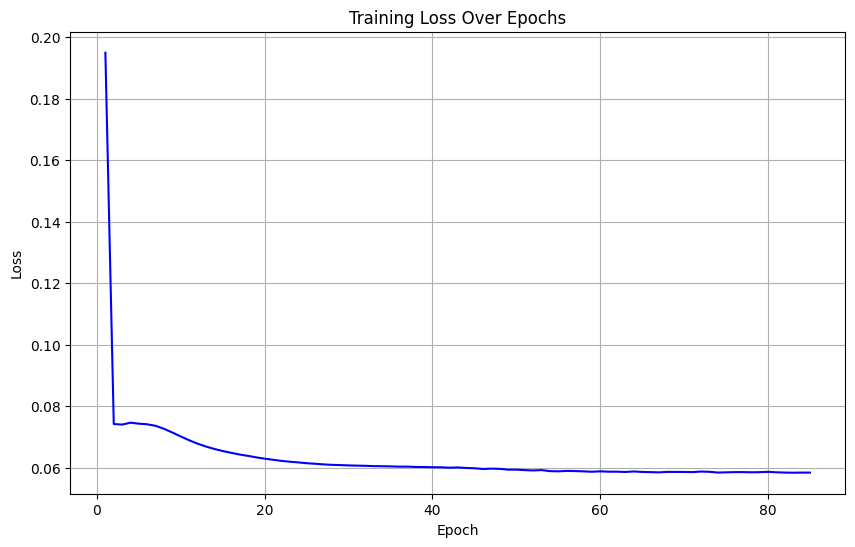

Training complete.


In [7]:
train(
    train_model,
    train_dataloader,
    w_path="../../Datasets/NYC_House_Price_Dataset/ST/train_weights/",
    num_epochs=500,
    optimizer_type='adam',
    lr=5e-3,
    input_indices=[0, 1, 2],
    patience=5,
    save_interval=25,
    loss_threshold=1e-4
)

# 4. Test the model

In [13]:
test_dataset = ST_dataloader(
        name=["long_term.npy", "short_term.npy", "ingredients.npy", "future.npy", "label.npy", "mask.npy"],
        root="../../Datasets/NYC_House_Price_Dataset/ST/test",
        transaction_cnt=False,
    )
test_dataloader = data.DataLoader(test_dataset, batch_size=8, shuffle=False)
test_global_min = test_dataset.global_min
test_global_max = test_dataset.global_max

In [14]:
test_model = ST_MMN(
    img_h = img_h,
    img_w = img_w,
    branches = [0, 1, 2],
    long_num_layers=2,
    long_frame_size = (img_h, img_w),
    short_num_layers=2,
    short_frame_size = (img_h, img_w),
    cur_ingred_dim = cur_ingred_dim,
    modalities = 3,
    indexs = [0, 1]
)

In [15]:
test_model.load_state_dict(torch.load("../../Datasets/NYC_House_Price_Dataset/ST/train_weights/best_model.pth"))

/tmp/ipykernel_5602/2332579494.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("../../Datasets/NYC_House_Price_Dataset/ST/train_wei

<All keys matched successfully>

In [17]:
def test(
    test_model,
    test_dataloader,
    input_indexs = [0, 1, 2, 3]
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_model = test_model.to(device)
    num_batches = 0
    rmse_total = 0.0
    conversion_rmse_total = 0.0
    
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = [batch[i].to(device) for i in input_indexs]
            labels = batch[-2].to(device)
            mask = batch[-1].to(device)
            
            predictions = test_model(inputs)
            rmse = rmse_loss(predictions, labels, mask)
            rmse_total += rmse.item() * labels.size(0)
            predictions = inverse_normalize(predictions, test_global_min[-1][0], test_global_max[-1][0])
            labels = inverse_normalize(labels, test_global_min[-1][0], test_global_max[-1][0])
            print("global min: ", test_global_min[-1][0])
            print("global max: ", test_global_max[-1][0])
            conversion_rmse = rmse_loss(predictions, labels, mask)
            conversion_rmse_total += conversion_rmse.item() * labels.size(0)
            num_batches += 1

    average_rmse = rmse_total / len(test_dataloader.dataset)
    average_conversion_rmse = conversion_rmse_total / len(test_dataloader.dataset)
    
    print(f"Average RMSE: {average_rmse}")
    print(f"Average Conversion RMSE: {average_conversion_rmse}")

In [18]:
test(train_model, train_dataloader, input_indexs=[0, 1, 2])

global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
global min:  0.0
global max:  7825000.0
Average RMSE: 0.058325798603995095
Average Conversion RMSE: 228199.6875


In [16]:
test(test_model, test_dataloader, [0, 1, 2])

without conversion: 
------------------------------------
with conversion: 
global min:  0.0
global max:  7825000.0
without conversion: 
------------------------------------
with conversion: 
global min:  0.0
global max:  7825000.0
Average RMSE: 0.08241728196541469
Average Conversion RMSE: 322457.6041666667
